In [2]:
import pandas as pd
import numpy as np


games_df = pd.read_csv("NEWDBS/Season-2010-2019.csv")
games_df["event_date"] = pd.to_datetime(games_df["event_date"])

# Coldrop array
cols_to_drop = [
    "status",
    "tm_nano", "opp_nano",
    "tm_market", "tm_name", "tm_alt_market",
    "opp_market", "opp_name", "opp_alt_market",
    "tm_alt_alias", "opp_alt_alias",
]
games_df = games_df.drop(columns=cols_to_drop)

# Regular season only (week 1–17)
games_df = games_df[games_df["week"].between(1, 17)].copy()

# Swap if team is NOT home and opp IS home
swap_home_mask = (games_df["tm_location"] != "H") & (games_df["opp_location"] == "H")

# True if either side has neutral location
neutral_mask = (games_df["tm_location"] == "N") | (games_df["opp_location"] == "N")
# If it's a neutral site, order alphabetically (this happens so extremely rarely, it's negligible)
swap_neutral_mask = (
    neutral_mask 
    & (games_df["tm_location"] != "H") 
    & (games_df["opp_location"] != "H") 
    & (games_df["tm_alias"] > games_df["opp_alias"]))
# True if NEITHER team is marked home

swap_mask = swap_home_mask | swap_neutral_mask
#True for rows that neew swapping for either home/away or neutral site reasons


# The pairs of rows that are getting switched by the swap masks
swap_pairs = [
    ("tm_alias", "opp_alias"), # Team
    ("tm_location", "opp_location"), # H/A/N
    ("tm_score", "opp_score"), # Score (obviously)
]


# The tm_ and opp_ will change so that tm is always home
for a, b in swap_pairs:
    tmp = games_df.loc[swap_mask, a].copy() # Selects rows that need swapping
    games_df.loc[swap_mask, a] = games_df.loc[swap_mask, b].values #
    games_df.loc[swap_mask, b] = tmp.values



# Targets
games_df["PointDiff"] = games_df["tm_score"] - games_df["opp_score"] # home margin (>0 is a win | <=0 is a loss)
games_df["Win"] = (games_df["PointDiff"] > 0).astype(int) # home win (1 = win, 0 = loss [for home team])

# Long format (one row per team-game)
# also renames columns to be easier to recognize
team_view_df = games_df[[
    "season","week","event_date","boxscore_stats_link",
    "tm_alias","opp_alias","tm_location","tm_score","opp_score","Win","PointDiff"
]].copy()
team_view_df.columns = [
    "season","week","event_date","game_id",
    "team","opponent","location","points_for","points_against","win","pt_diff"
]

# Recompute pt_diff & win from new score columns
team_view_df["pt_diff"] = team_view_df["points_for"] - team_view_df["points_against"]
team_view_df["win"] = (team_view_df["pt_diff"] > 0).astype(int)


# Takes data for opponent row
opp_view_df = games_df[[
    "season","week","event_date","boxscore_stats_link",
    "opp_alias","tm_alias","opp_location","opp_score","tm_score","PointDiff"
]].copy()
opp_view_df.columns = [
    "season","week","event_date","game_id",
    "team","opponent","location","points_for","points_against","pt_diff"
]
opp_view_df["win"] = (opp_view_df["pt_diff"] < 0).astype(int)  # opponent wins if tm lost
opp_view_df["pt_diff"] = -opp_view_df["pt_diff"]


# Stack datasets, makes each game have 2 rows (one per team)
team_games_df = pd.concat([team_view_df, opp_view_df], ignore_index=True)
# Put each team's game in chronological order
team_games_df = team_games_df.sort_values(["team", "season", "event_date", "week", "game_id"]).reset_index(drop=True)

# Rolling features (last 3/5/8 games)
rolling_windows = [3, 5, 8]

# Group by team & season (so week 1 doesn't use last year's games in rolling stats)
team_season_group = team_games_df.groupby(["team", "season"], group_keys=False)

# min_periods = n-1 (remember because of shift(1) thing I did) so ONLY prior games count
for n in rolling_windows:
    min_prev_games = n # Only compute rolling average when there are enough games played to calculate it
    # Since it's week 3/5/8, that means rolling averages technically are for weeks 4/6/9

    # Ok this is how the rolling window works:
    # s.shift(1) shifts the series down 1 so that the current game is EXCLUDED
    # rolling(n) takes the last n values of the shifted series
    # Sum is for total over those prior 3/5/8 games

    # This one is for how many points a team gives up
    team_games_df[f"PtsAgainst{n}"] = team_season_group["points_against"].apply(
        lambda s: s.shift(1).rolling(n, min_periods=min_prev_games).sum()
    )
    # This one is for how many points a team scores
    team_games_df[f"PtsFor{n}"] = team_season_group["points_for"].apply(
        lambda s: s.shift(1).rolling(n, min_periods=min_prev_games).sum()
    )
    # This one is the sum of all point differences to get a view if a team is buns or not
    team_games_df[f"PtDifference{n}"] = team_season_group["pt_diff"].apply(
        lambda s: s.shift(1).rolling(n, min_periods=min_prev_games).sum()
    )

    # This is for total wins in last N games
    team_games_df[f"WinLoss{n}"] = team_season_group["win"].apply(
        lambda s: s.shift(1).rolling(n, min_periods=min_prev_games).sum()
    )


# Rest days/time between games
team_season_group_for_rest = team_games_df.groupby(["team", "season"], group_keys=False)
team_games_df["RestDays"] = team_season_group_for_rest["event_date"].apply(lambda s: s.diff().dt.days)

# Season-to-date features (shifted to exclude current game)
team_season_group2 = team_games_df.groupby(["team", "season"], group_keys=False)
team_games_df["SznFor"] = team_season_group2["points_for"].apply(lambda s: s.shift(1).expanding(min_periods=1).sum())
team_games_df["SznAgainst"] = team_season_group2["points_against"].apply(lambda s: s.shift(1).expanding(min_periods=1).sum())
# For game 1, the shift makes it all NaN since there's no prior values, DON'T TOUCH IT OR IT *WILL* BREAK

# Record vs opponent in last 3 seasons (win rate)
def record3year(group: pd.DataFrame) -> pd.Series:
    group = group.sort_values(["event_date", "week", "game_id"]) # Sort chronologically
    past = []  # (season, win)
    out = []
    for _, row in group.iterrows():
        cutoff = row["season"] - 2  # Current season + previous 2 = 3 seasons
        vals = [w for (s, w) in past if s >= cutoff]
        # Mean win rate, BUT if no matchup history is present, then output NaN
        out.append(np.mean(vals) if vals else np.nan)
        # Adds current game rtesult AFTER computing history
        past.append((
            row["season"], 
            row["win"]
        ))
    return pd.Series(out, index=group.index)

# Group by each team/opponent pairing across seasons
team_games_df["Record3Year"] = team_games_df.groupby(
    ["team", "opponent"], group_keys=False).apply(record3year)

# Merge features back (teamm + opp versions)
feature_cols = []
for n in rolling_windows:
    feature_cols += [f"PtsAgainst{n}", f"PtsFor{n}", f"PtDifference{n}", f"WinLoss{n}"]
feature_cols += ["SznFor", "SznAgainst", "Record3Year", "RestDays"]

# For each game/team, add the engineered features
team_features_df = team_games_df[["game_id", "team"] + feature_cols].copy()
# Make second df with opponent data (non-home team)
opp_features_df = team_features_df.rename(columns={c: f"Opp_{c}" for c in feature_cols})


# Merges home team engineered features
final_df = games_df.merge(
    team_features_df, left_on=["boxscore_stats_link", "tm_alias"], 
    right_on=["game_id", "team"], 
    how="left"
).merge(
    opp_features_df, left_on=["boxscore_stats_link",
                              "opp_alias"], right_on=["game_id", "team"], how="left"
) # Same thing but for opponent features ^
# Drop merge helper columns
final_df = final_df.drop(columns=["game_id_x","team_x","game_id_y","team_y"], errors="ignore")

# Neutral Site indicator
final_df["NeutralSite"] = ((final_df["tm_location"]=="N") | (final_df["opp_location"]=="N")).astype(int)
final_df = final_df.drop(columns=["tm_location","opp_location"])
# Neutralsite = 1 if either is neutral


# NaN handling
# 1) Rolling totals: add flags then fill NaNs with 0. Pls don't touch this part <3
for n in rolling_windows:
    final_df[f"HasRolling{n}"] = final_df[f"PtsFor{n}"].notna().astype(int)
    final_df[f"Opp_HasRolling{n}"] = final_df[f"Opp_PtsFor{n}"].notna().astype(int)

    roll_cols = [
        f"PtsAgainst{n}", f"PtsFor{n}", f"PtDifference{n}", f"WinLoss{n}",
        f"Opp_PtsAgainst{n}", f"Opp_PtsFor{n}", f"Opp_PtDifference{n}", f"Opp_WinLoss{n}",
    ]
    # This is so that the 0's in the beginning for rolling don't actually count as "real" 0's
    final_df[roll_cols] = final_df[roll_cols].fillna(0)

# Season-to-date totals- week 1 will be 0 prior points
final_df["HasSzn"] = final_df["SznFor"].notna().astype(int)
final_df["Opp_HasSzn"] = final_df["Opp_SznFor"].notna().astype(int)

# Fill with 0s to show no recorded scores yet
szn_cols = ["SznFor", "SznAgainst", "Opp_SznFor", "Opp_SznAgainst"]
final_df[szn_cols] = final_df[szn_cols].fillna(0)

# Rest days - week 1 has no prior game, so I filled it with 7 (default amount of rest) & keep a flag
final_df["HasRest"] = final_df["RestDays"].notna().astype(int)
final_df["Opp_HasRest"] = final_df["Opp_RestDays"].notna().astype(int)

final_df[["RestDays", "Opp_RestDays"]] = final_df[["RestDays", "Opp_RestDays"]].fillna(7)

# 4) Record vs opponent last 3 seasons if NaN, use 0.5 and keep a flag
final_df["HasRecord3Year"] = final_df["Record3Year"].notna().astype(int)
final_df["Opp_HasRecord3Year"] = final_df["Opp_Record3Year"].notna().astype(int)
final_df[["Record3Year", "Opp_Record3Year"]] = final_df[["Record3Year", "Opp_Record3Year"]].fillna(0.5)


####################################
# Keep this just in case if I need to drop this bc it only kicks in literally haflway thru the season:
#final_df = final_df.dropna(subset=["PtsFor8", "Opp_PtsFor8"])


# Difference features (team - opp)
for n in rolling_windows:
    final_df[f"PtsFor{n}Diff"]       = final_df[f"PtsFor{n}"] - final_df[f"Opp_PtsFor{n}"]
    final_df[f"PtsAgainst{n}Diff"]   = final_df[f"PtsAgainst{n}"] - final_df[f"Opp_PtsAgainst{n}"]
    final_df[f"PtDifference{n}Diff"] = final_df[f"PtDifference{n}"] - final_df[f"Opp_PtDifference{n}"]
    final_df[f"WinLoss{n}Diff"]      = final_df[f"WinLoss{n}"] - final_df[f"Opp_WinLoss{n}"]

final_df["SznForDiff"]      = final_df["SznFor"] - final_df["Opp_SznFor"]
final_df["SznAgainstDiff"]  = final_df["SznAgainst"] - final_df["Opp_SznAgainst"]
final_df["Record3YearDiff"] = final_df["Record3Year"] - final_df["Opp_Record3Year"]


final_df.to_csv("NEWDBS/Season-2010-2019ExtraFeatures.csv", index=False)
print(final_df.shape)

(2560, 71)


C:\Users\Chenz\AppData\Local\Temp\ipykernel_3980\1528398151.py:142: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_games_df["Record3Year"] = team_games_df.groupby(["team", "opponent"], group_keys=False).apply(record3year)


Train shape: (2304, 61) Test shape: (256, 61)

===== 2019 TEST METRICS =====
Win Accuracy: 0.6055
Confusion Matrix:
 [[ 49  75]
 [ 26 106]]
PointDiff MAE:  10.981
PointDiff RMSE: 14.058


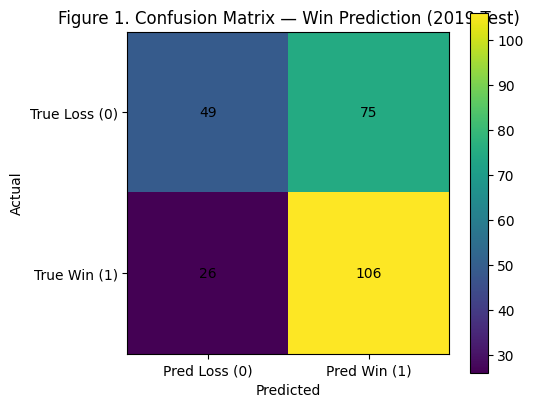

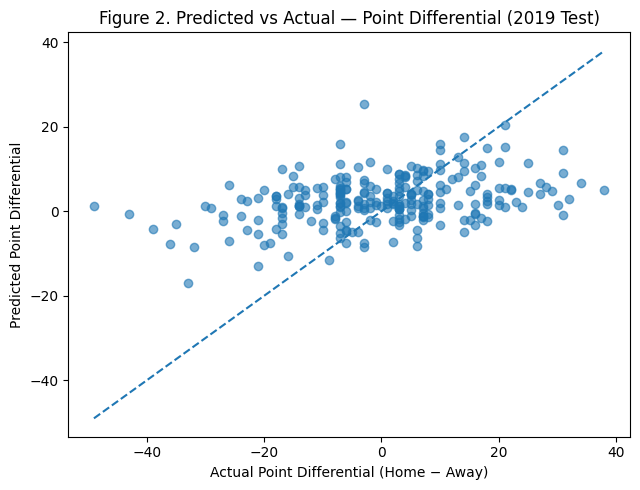


===== FIGURE CAPTIONS (COPY/PASTE) =====
Figure 1. Confusion matrix for the Win classifier evaluated on the 2019 NFL season test set. Rows represent the true game outcome and columns represent the predicted outcome. This figure summarizes how many games were correctly classified as wins/losses and where the model made mistakes.
Figure 2. Predicted versus actual point differential (home score − away score) for the regression model on the 2019 test set. Points closer to the dashed diagonal line indicate more accurate predictions. Overall prediction error is summarized by MAE = 10.98 and RMSE = 14.06.

Saved files:
 - fig1_confusion_matrix_win_2019.png
 - fig2_pred_vs_actual_pointdiff_2019.png


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# Load
# -----------------------------
df = pd.read_csv("NEWDBS/Season-2010-2019ExtraFeatures.csv")

# -----------------------------
# Build features X and targets y (NO leakage)
# -----------------------------
y_win = df["Win"].astype(int).values
y_pd  = df["PointDiff"].astype(float).values

drop_cols = [
    "Win", "PointDiff",
    "tm_score", "opp_score",                  # leakage (current game score)
    "boxscore_stats_link", "event_date", "week_day",
    "tm_alias", "opp_alias",
    "season"                                   # remove year from inputs
]

X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()  # numeric only
X = X.fillna(0)                                  # simple NaN handling

# -----------------------------
# Train/Test split (2010-2018 train, 2019 test)
# -----------------------------
train_mask = df["season"].between(2010, 2018)
test_mask  = df["season"] == 2019

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
ywin_train, ywin_test = y_win[train_mask], y_win[test_mask]
ypd_train, ypd_test   = y_pd[train_mask], y_pd[test_mask]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# -----------------------------
# Simple models (fast + reliable)
# -----------------------------
win_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pd_model = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Ridge(alpha=1.0))
])

win_model.fit(X_train, ywin_train)
pd_model.fit(X_train, ypd_train)

# -----------------------------
# Predictions + metrics
# -----------------------------
win_pred = win_model.predict(X_test)
pd_pred  = pd_model.predict(X_test)

acc = accuracy_score(ywin_test, win_pred)
cm = confusion_matrix(ywin_test, win_pred)

mae = mean_absolute_error(ypd_test, pd_pred)
rmse = np.sqrt(mean_squared_error(ypd_test, pd_pred))

print("\n===== 2019 TEST METRICS =====")
print(f"Win Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)
print(f"PointDiff MAE:  {mae:.3f}")
print(f"PointDiff RMSE: {rmse:.3f}")

# =========================================================
# FIGURE 1: Confusion Matrix (Win)
# =========================================================
plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm)
plt.xticks([0, 1], ["Pred Loss (0)", "Pred Win (1)"])
plt.yticks([0, 1], ["True Loss (0)", "True Win (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Figure 1. Confusion Matrix — Win Prediction (2019 Test)")
plt.colorbar()

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha="center", va="center")

plt.tight_layout()
plt.savefig("NEWDBS/Figure 1. Confusion Matrix — Win Prediction (2019 Test).png", dpi=300)
plt.show()

# =========================================================
# FIGURE 2: Predicted vs Actual (Point Differential)
# =========================================================
plt.figure(figsize=(6.5, 5))
plt.scatter(ypd_test, pd_pred, alpha=0.6)

min_v = float(min(np.min(ypd_test), np.min(pd_pred)))
max_v = float(max(np.max(ypd_test), np.max(pd_pred)))
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")

plt.xlabel("Actual Point Differential (Home − Away)")
plt.ylabel("Predicted Point Differential")
plt.title("Figure 2. Predicted vs Actual — Point Differential (2019 Test)")
plt.tight_layout()
plt.savefig("NEWDBS/Figure 2. Prediction vs Actual Point Differential (2019 Test).png", dpi=300)
plt.show()

# -----------------------------
# Captions (copy/paste)
# -----------------------------
print("\n===== FIGURE CAPTIONS (COPY/PASTE) =====")
print(
    "Figure 1. Confusion matrix for the Win classifier evaluated on the 2019 NFL season test set. "
    "Rows represent the true game outcome and columns represent the predicted outcome. "
    "This figure summarizes how many games were correctly classified as wins/losses and where the model made mistakes."
)
print(
    "Figure 2. Predicted versus actual point differential (home score − away score) for the regression model on the 2019 test set. "
    "Points closer to the dashed diagonal line indicate more accurate predictions. "
    f"Overall prediction error is summarized by MAE = {mae:.2f} and RMSE = {rmse:.2f}."
)

print("\nSaved files:")
print(" - fig1_confusion_matrix_win_2019.png")
print(" - fig2_pred_vs_actual_pointdiff_2019.png")

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv("NEWDBS/Season-2010-2019ExtraFeatures.csv")

# --- SPLIT BY SEASON (like your notebook) ---
train_df = df[df["season"] <= 2017].copy()
val_df   = df[df["season"] == 2018].copy()
test_df  = df[df["season"] == 2019].copy()

# --- TARGETS ---
y_win_train = train_df["Win"].astype(int).values
y_win_val   = val_df["Win"].astype(int).values
y_win_test  = test_df["Win"].astype(int).values

y_pd_train = train_df["PointDiff"].astype(float).values
y_pd_val   = val_df["PointDiff"].astype(float).values
y_pd_test  = test_df["PointDiff"].astype(float).values

# --- FEATURES: DROP LEAKY + ID + NON-NUMERIC ---
drop_cols = [
    "Win", "PointDiff",
    "tm_score", "opp_score",          # leakage
    "boxscore_stats_link",            # ID
    "event_date", "week_day",         # non-numeric unless encoded
    "tm_alias", "opp_alias"           # optional (later you can embed these)
]

X_train = train_df.drop(columns=drop_cols, errors="ignore")
X_val   = val_df.drop(columns=drop_cols, errors="ignore")
X_test  = test_df.drop(columns=drop_cols, errors="ignore")

# Keep only numeric columns (extra safety)
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_val   = X_val.apply(pd.to_numeric, errors="coerce")
X_test  = X_test.apply(pd.to_numeric, errors="coerce")

# NaNs: if your feature engineering already filled them, this does nothing;
# if not, it prevents crashes.
X_train = X_train.fillna(0)
X_val   = X_val.fillna(0)
X_test  = X_test.fillna(0)

print("X shape:", X_train.shape, X_val.shape, X_test.shape)
print("Win  distribution (train):", np.mean(y_win_train))
print("PointDiff mean/std (train):", np.mean(y_pd_train), np.std(y_pd_train))

X shape: (2048, 62) (256, 62) (256, 62)
Win  distribution (train): 0.5673828125
PointDiff mean/std (train): 2.47509765625 14.673908771124202


In [22]:
normalizer = layers.Normalization()
normalizer.adapt(X_train.values)

win_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    normalizer,
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(1, activation="sigmoid")
])

win_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc")
    ]
)

print("\nWIN MODEL SUMMARY:")
win_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True)
]

history_win = win_model.fit(
    X_train.values, y_win_train,
    validation_data=(X_val.values, y_win_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n2019 TEST (WIN):", win_model.evaluate(X_test.values, y_win_test, verbose=0))



WIN MODEL SUMMARY:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization)      │ (None, 62)                  │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,510 (64.50 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 125 (504.00 B)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5908 - auc: 0.6040 - loss: 0.6875 - val_accuracy: 0.6211 - val_auc: 0.6352 - val_loss: 0.6460
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5957 - auc: 0.6304 - loss: 0.6655 - val_accuracy: 0.6094 - val_auc: 0.6446 - val_loss: 0.6408
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6230 - auc: 0.6650 - loss: 0.6429 - val_accuracy: 0.6367 - val_auc: 0.6512 - val_loss: 0.6470
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6221 - auc: 0.6659 - loss: 0.6438 - val_accuracy: 0.6094 - val_auc: 0.6546 - val_loss: 0.6403
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6255 - auc: 0.6644 - loss: 0.6411 - val_accuracy: 0.6133 - val_auc: 0.6498 - val_loss: 0.6452
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6353 - auc: 0.6797 - loss: 0.6318 - val_accuracy: 0.6172 - val_auc: 0.6455 - val_loss: 0.6393
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

In [23]:
pd_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    normalizer,  # reuse the same normalizer fit on X_train
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(1)  # linear output for regression
])

pd_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.Huber(),  # robust vs blowouts
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

print("\nPOINTDIFF MODEL SUMMARY:")
pd_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_rmse", mode="min", patience=10, restore_best_weights=True)
]

history_pd = pd_model.fit(
    X_train.values, y_pd_train,
    validation_data=(X_val.values, y_pd_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n2019 TEST (POINTDIFF):", pd_model.evaluate(X_test.values, y_pd_test, verbose=0))

# Optional: convert predicted PointDiff -> implied Win and score it
pred_pd = pd_model.predict(X_test.values, verbose=0).ravel()
pred_win_from_pd = (pred_pd > 0).astype(int)
print("2019 implied Win accuracy from PointDiff sign:", np.mean(pred_win_from_pd == y_win_test))


POINTDIFF MODEL SUMMARY:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization)      │ (None, 62)                  │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,510 (64.50 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 125 (504.00 B)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.7215 - mae: 11.2131 - rmse: 14.4352 - val_loss: 9.7873 - val_mae: 10.2684 - val_rmse: 13.6954
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10.3461 - mae: 10.8341 - rmse: 13.9623 - val_loss: 9.7476 - val_mae: 10.2265 - val_rmse: 13.6233
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.3667 - mae: 10.8582 - rmse: 13.9935 - val_loss: 9.7231 - val_mae: 10.2101 - val_rmse: 13.6042
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.2631 - mae: 10.7516 - rmse: 13.8923 - val_loss: 9.6964 - val_mae: 10.1859 - val_rmse: 13.5830
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.2627 - mae: 10.7519 - rmse: 13.8962 - val_loss: 9.7582 - val_mae: 10.2410 - val_rmse: 13.6402
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.2068 - mae: 10.6944 - rmse: 13.8490 - val_loss: 9.7199 - val_mae: 10.2035 - val_rmse: 13.6212
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.16

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv("NEWDBS/Season-2010-2019ExtraFeatures.csv")

# --- targets ---
y_win = df["Win"].astype("float32").values
y_pd  = df["PointDiff"].astype("float32").values

# --- build X (drop leakage + non-numeric identifiers) ---
drop_cols = [
    "Win", "PointDiff",
    "tm_score", "opp_score",                 # leakage (current game score)
    "boxscore_stats_link", "event_date", "week_day",
    "tm_alias", "opp_alias",
    "season"                                 # don’t let the model “use the year”
]

X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()  # keep only numeric features

# --- NaN handling (NN-safe): add missing flags, fill NaNs with 0 ---
X_isna = X.isna().astype("int8")
X_isna.columns = [f"{c}_isna" for c in X.columns]
X = pd.concat([X.fillna(0), X_isna], axis=1)

# --- time-aware split ---
train_mask = df["season"].between(2010, 2017)
val_mask   = df["season"] == 2018
test_mask  = df["season"] == 2019

X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
ywin_train, ywin_val, ywin_test = y_win[train_mask], y_win[val_mask], y_win[test_mask]
ypd_train, ypd_val, ypd_test    = y_pd[train_mask], y_pd[val_mask], y_pd[test_mask]

print(X_train.shape, X_test.shape)

(2048, 122) (256, 122)


In [17]:
normalizer = layers.Normalization()
normalizer.adapt(X_train.values)

win_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    normalizer,
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(1, activation="sigmoid"),
])

win_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5),
]

win_model.fit(
    X_train.values, ywin_train,
    validation_data=(X_val.values, ywin_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("2019 test:", win_model.evaluate(X_test.values, ywin_test, verbose=0))

# Example: predicted winners for 2019
p_win_2019 = win_model.predict(X_test.values).reshape(-1)
pred_win_2019 = (p_win_2019 >= 0.5).astype(int)

print("\n===== Win Model Summary =====")
win_model.summary()

print("\n===== Win Evaluation (2019 Test) =====")
test_loss, test_acc, test_auc = win_model.evaluate(X_test.values, ywin_test, verbose=0)
print(f"Test loss (BCE): {test_loss:.4f}")
print(f"Test Accuracy:   {test_acc:.4f}")
print(f"Test AUC:        {test_auc:.4f}")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5869 - auc: 0.6091 - loss: 0.6760 - val_accuracy: 0.5977 - val_auc: 0.6199 - val_loss: 0.6516 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6025 - auc: 0.6328 - loss: 0.6578 - val_accuracy: 0.6133 - val_auc: 0.6406 - val_loss: 0.6536 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6177 - auc: 0.6510 - loss: 0.6469 - val_accuracy: 0.6328 - val_auc: 0.6474 - val_loss: 0.6433 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6299 - auc: 0.6611 - loss: 0.6422 - val_accuracy: 0.6250 - val_auc: 0.6410 - val_loss: 0.6469 - learning_rate: 0.0010
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6274 - auc: 0.6630 - loss: 0.6434 - val_accuracy: 0.6406 - val_auc: 0.6457 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6431 - auc: 0.6677 -

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (None, 122)                 │             245 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           7,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,202 (117.98 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 245 (984.00 B)

 Optimizer params: 19,972 (78.02 KB)


===== Win Evaluation (2019 Test) =====
Test loss (BCE): 0.6638
Test Accuracy:   0.5898
Test AUC:        0.6334


In [18]:
normalizer2 = layers.Normalization()
normalizer2.adapt(X_train.values)

pd_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    normalizer2,
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.20),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.20),
    layers.Dense(1)
])

pd_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.Huber(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

history_pd = pd_model.fit(
    X_train.values, ypd_train,
    validation_data=(X_val.values, ypd_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n===== PointDiff Model Summary =====")
pd_model.summary()

print("\n===== PointDiff Evaluation (2019 Test) =====")
test_loss, test_mae, test_rmse = pd_model.evaluate(X_test.values, ypd_test, verbose=0)
print(f"Test loss (Huber): {test_loss:.4f}")
print(f"Test MAE:          {test_mae:.4f}")
print(f"Test RMSE:         {test_rmse:.4f}")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.8513 - mae: 11.3435 - rmse: 14.5743 - val_loss: 9.9491 - val_mae: 10.4364 - val_rmse: 13.9089 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4066 - mae: 10.8964 - rmse: 14.0886 - val_loss: 9.7678 - val_mae: 10.2501 - val_rmse: 13.6852 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.3597 - mae: 10.8494 - rmse: 14.0124 - val_loss: 9.7148 - val_mae: 10.1914 - val_rmse: 13.6325 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.3185 - mae: 10.8095 - rmse: 13.9302 - val_loss: 9.7066 - val_mae: 10.1867 - val_rmse: 13.5807 - learning_rate: 0.0010
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.2758 - mae: 10.7660 - rmse: 13.9028 - val_loss: 9.6969 - val_mae: 10.1819 - val_rmse: 13.5777 - learning_rate: 0.0010
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.3001 - mae: 10.7907 - rmse: 13.9677 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization)      │ (None, 122)                 │             245 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           7,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,202 (117.98 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 245 (984.00 B)

 Optimizer params: 19,972 (78.02 KB)


===== PointDiff Evaluation (2019 Test) =====
Test loss (Huber): 10.8547
Test MAE:          11.3478
Test RMSE:         14.5515


In [19]:
print("\nLast epoch (Win):", {k: v[-1] for k, v in history_win.history.items()})
print("Last epoch (PD):",  {k: v[-1] for k, v in history_pd.history.items()})

NameError: name 'history_win' is not defined

ValueError: Exception encountered when calling Normalization.call().

[1mDimensions must be equal, but are 122 and 62 for '{{node sequential_4_1/normalization_4_1/Sub}} = Sub[T=DT_FLOAT](data, sequential_4_1/normalization_4_1/Sub/y)' with input shapes: [32,122], [1,62].[0m

Arguments received by Normalization.call():
  • inputs=tf.Tensor(shape=(32, 122), dtype=float32)